In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_leases=pd.read_csv('leases.csv')
df_leases.head()

,id,unit_id,tenant_id,rent_per_month,arrears,start_date,end_date
0,1,1,1,45000,0,01/01/2024,NaN
1,2,2,2,55000,5000,01/11/2023,31/10/2024
2,3,3,3,65000,-2000,01/02/2024,NaN
3,4,4,4,-30000,1000,01/03/2024,NaN
4,5,5,3,70000,0,01/02/2025,31/12/2025


In [3]:
df_leases.shape

(12, 7)

In [4]:
df_leases['rent_per_month']=df_leases['rent_per_month'].abs()
df_leases['arrears']=df_leases['arrears'].abs()

df_leases.head()

,id,unit_id,tenant_id,rent_per_month,arrears,start_date,end_date
0,1,1,1,45000,0,01/01/2024,NaN
1,2,2,2,55000,5000,01/11/2023,31/10/2024
2,3,3,3,65000,2000,01/02/2024,NaN
3,4,4,4,30000,1000,01/03/2024,NaN
4,5,5,3,70000,0,01/02/2025,31/12/2025


In [5]:
df_leases.isnull().sum()

id                0
unit_id           0
tenant_id         0
rent_per_month    0
arrears           0
start_date        0
end_date          5
dtype: int64

In [6]:
df_leases.duplicated().sum()

np.int64(0)

In [7]:
from datetime import date

In [8]:
df_leases['start_date']=pd.to_datetime(df_leases['start_date'], format='%d/%m/%Y')
df_leases['end_date']=pd.to_datetime(df_leases['end_date'])

In [9]:
today=pd.Timestamp.now().normalize()

In [10]:
calc_end_date=df_leases['end_date'].fillna(today)

In [11]:
df_leases['annual_rent']=df_leases['rent_per_month'] * 12
df_leases.head()

,id,unit_id,tenant_id,rent_per_month,arrears,start_date,end_date,annual_rent
0,1,1,1,45000,0,2024-01-01,NaT,540000
1,2,2,2,55000,5000,2023-11-01,2024-10-31,660000
2,3,3,3,65000,2000,2024-02-01,NaT,780000
3,4,4,4,30000,1000,2024-03-01,NaT,360000
4,5,5,3,70000,0,2025-02-01,2025-12-31,840000


In [12]:
df_leases['valid_lease'] = (
    ((df_leases['end_date'].isna() & (df_leases['start_date'] <= today)) |
     (df_leases['start_date'] < df_leases['end_date']))
    .astype(int)
)

In [13]:
def get_status(row):
    if pd.isna(row['end_date']) and row['start_date'] <= today:
        return 'ongoing'
    elif pd.notna(row['end_date']) and row['end_date'] > today:
        return 'ongoing'
    elif pd.notna(row['end_date']) and row['end_date'] <= today:
        return 'expired'
    else:
        return 'invalid'

In [14]:
df_leases['lease_status'] = df_leases.apply(get_status, axis=1)

In [15]:
df_leases.head()

,id,unit_id,tenant_id,rent_per_month,arrears,start_date,end_date,annual_rent,valid_lease,lease_status
0,1,1,1,45000,0,2024-01-01,NaT,540000,1,ongoing
1,2,2,2,55000,5000,2023-11-01,2024-10-31,660000,1,expired
2,3,3,3,65000,2000,2024-02-01,NaT,780000,1,ongoing
3,4,4,4,30000,1000,2024-03-01,NaT,360000,1,ongoing
4,5,5,3,70000,0,2025-02-01,2025-12-31,840000,1,ongoing


In [16]:
df_locations=pd.read_csv('locations.csv', sep=';')
df_locations.head()

,id,name
0,1,Nairobi CBD
1,2,Westlands
2,3,Kilimani


In [17]:
df_locations['name'] = df_locations['name'].str.title()

In [18]:
df_properties=pd.read_csv('properties.csv', sep=';')
df_properties.head()

,id,name,location_id
0,1,NSSF Towers,1
1,2,Delta Corner,2
2,3,The Junction Residences,3
3,4,Riverside Court,2
4,5,Kimathi House,1


In [19]:
df_properties.isnull().sum()

id             0
name           0
location_id    0
dtype: int64

In [20]:
df_tenants=pd.read_csv('tenants.csv', sep=';')
df_tenants.head()

,id,name,email
0,1,Amina Mwangi,amina.mwangi@example.com
1,2,Brian Otieno,brian.otieno@example.com
2,3,Carol Wanjiru,carol.wanjiru@example.com
3,4,David Kiptoo,david.kiptoo@example.com
4,5,Eunice Njeri,eunice.njeri@example.com


In [21]:
df_tenants.isnull().sum()

id       0
name     0
email    1
dtype: int64

In [22]:
df_units=pd.read_csv('units.csv', sep=';')
df_units.head()

,id,property_id,name,size
0,1,1,A-101,75.0
1,2,1,A-102,80.5
2,3,1,B-201,65.0
3,4,1,B-202,92.0
4,5,1,C-301,120.0


In [23]:
df_units.isnull().sum()

id             0
property_id    0
name           0
size           0
dtype: int64

In [24]:
# 1. Merge leases and units
df_cleaned = pd.merge(df_leases, df_units, left_on='unit_id', right_on='id', suffixes=('_lease', '_unit'))
df_cleaned.rename(columns={'name': 'unit_name', 'size': 'unit_size'}, inplace=True)
df_cleaned.drop(columns=['id_unit'], inplace=True)

In [25]:
# 2. Merge with properties
df_cleaned = pd.merge(df_cleaned, df_properties, left_on='property_id', right_on='id', suffixes=('_unit', '_property'))
df_cleaned.rename(columns={'name': 'property_name'}, inplace=True)
df_cleaned.drop(columns=['id'], inplace=True)

# 3. Merge with locations
df_cleaned = pd.merge(df_cleaned, df_locations, left_on='location_id', right_on='id', suffixes=('_property', '_location'))
df_cleaned.rename(columns={'name': 'location_name'}, inplace=True)
df_cleaned.drop(columns=['id', 'location_id', 'property_id'], inplace=True) # Drop foreign keys

In [26]:
# 4. Merge with tenants
df_cleaned = pd.merge(df_cleaned, df_tenants, left_on='tenant_id', right_on='id', suffixes=('_lease', '_tenant'))
df_cleaned.rename(columns={'name': 'tenant_name', 'email': 'tenant_email'}, inplace=True)
df_cleaned.drop(columns=['id', 'tenant_id', 'unit_id'], inplace=True) # Drop remaining foreign keys

In [27]:
# Rename remaining ID column to lease_id for clarity
df_cleaned.rename(columns={'id_lease': 'lease_id'}, inplace=True)

# Reorder columns
final_columns = ['lease_id', 'tenant_name', 'tenant_email', 'property_name', 'location_name', 'unit_name', 'unit_size',
                 'rent_per_month', 'annual_rent', 'arrears', 'start_date', 'end_date',
                 'lease_duration_months', 'lease_status', 'valid_lease']
df_cleaned = df_cleaned[[col for col in final_columns if col in df_cleaned.columns]]

In [28]:
df_cleaned.head()

,lease_id,tenant_name,tenant_email,property_name,location_name,unit_name,unit_size,rent_per_month,annual_rent,arrears,start_date,end_date,lease_status,valid_lease
0,1,Amina Mwangi,amina.mwangi@example.com,NSSF Towers,Nairobi Cbd,A-101,75.0,45000,540000,0,2024-01-01,NaT,ongoing,1
1,2,Brian Otieno,brian.otieno@example.com,NSSF Towers,Nairobi Cbd,A-102,80.5,55000,660000,5000,2023-11-01,2024-10-31,expired,1
2,3,Carol Wanjiru,carol.wanjiru@example.com,NSSF Towers,Nairobi Cbd,B-201,65.0,65000,780000,2000,2024-02-01,NaT,ongoing,1
3,4,David Kiptoo,david.kiptoo@example.com,NSSF Towers,Nairobi Cbd,B-202,92.0,30000,360000,1000,2024-03-01,NaT,ongoing,1
4,5,Carol Wanjiru,carol.wanjiru@example.com,NSSF Towers,Nairobi Cbd,C-301,120.0,70000,840000,0,2025-02-01,2025-12-31,ongoing,1


In [29]:
Task_1=df_cleaned.to_csv('C:/Users/Administrator/Desktop/Task_1.csv')

In [30]:
df_rent_arrears = df_cleaned[df_cleaned['valid_lease'] == 1].groupby('location_name').agg(
    total_rent_billed=('rent_per_month', 'sum'),
    total_arrears=('arrears', 'sum')
).reset_index()

In [31]:
df_rent_arrears_melted = df_rent_arrears.melt('location_name', var_name='Metric', value_name='Amount')

In [32]:
occupied_units = df_cleaned[df_cleaned['valid_lease'] == 1].drop_duplicates(subset='unit_name')
df_occupied_count = occupied_units.groupby('property_name').size().reset_index(name='occupied_units')

In [33]:
df_units_properties = pd.merge(df_units, df_properties, left_on='property_id', right_on='id', suffixes=('_unit', '_property'))
df_total_units_count = df_units_properties.groupby('name_property').size().reset_index(name='total_units')
df_total_units_count.rename(columns={'name_property': 'property_name'}, inplace=True)

In [34]:
df_occupancy = pd.merge(df_total_units_count, df_occupied_count, on='property_name', how='left').fillna(0)
df_occupancy['occupancy_rate'] = (df_occupancy['occupied_units'] / df_occupancy['total_units']) * 100

Total Monthly Rent Billed vs Total Arrears by Location

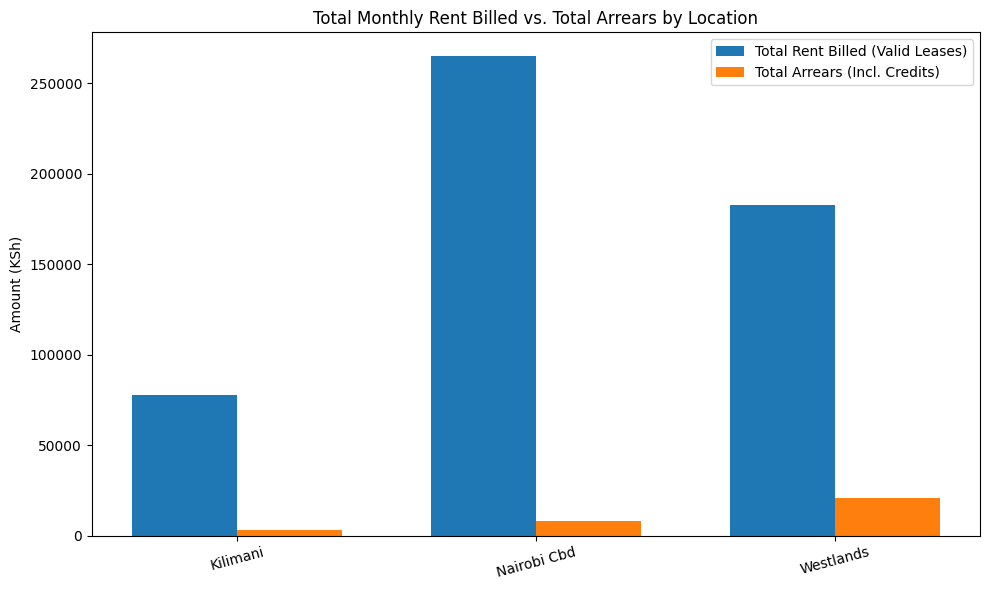

In [35]:
df_rent_arrears = df_cleaned[df_cleaned['valid_lease'] == 1].groupby('location_name').agg(
    total_rent_billed=('rent_per_month', 'sum'),
    total_arrears=('arrears', 'sum')
).reset_index()

X_axis = np.arange(len(df_rent_arrears['location_name']))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(X_axis - width/2, df_rent_arrears['total_rent_billed'], width, label='Total Rent Billed (Valid Leases)')
plt.bar(X_axis + width/2, df_rent_arrears['total_arrears'], width, label='Total Arrears (Incl. Credits)')

plt.xticks(X_axis, df_rent_arrears['location_name'], rotation=15)
plt.ylabel('Amount (KSh)')
plt.title('Total Monthly Rent Billed vs. Total Arrears by Location')
plt.legend()
plt.tight_layout()
plt.show()

Occupancy Rate per Property

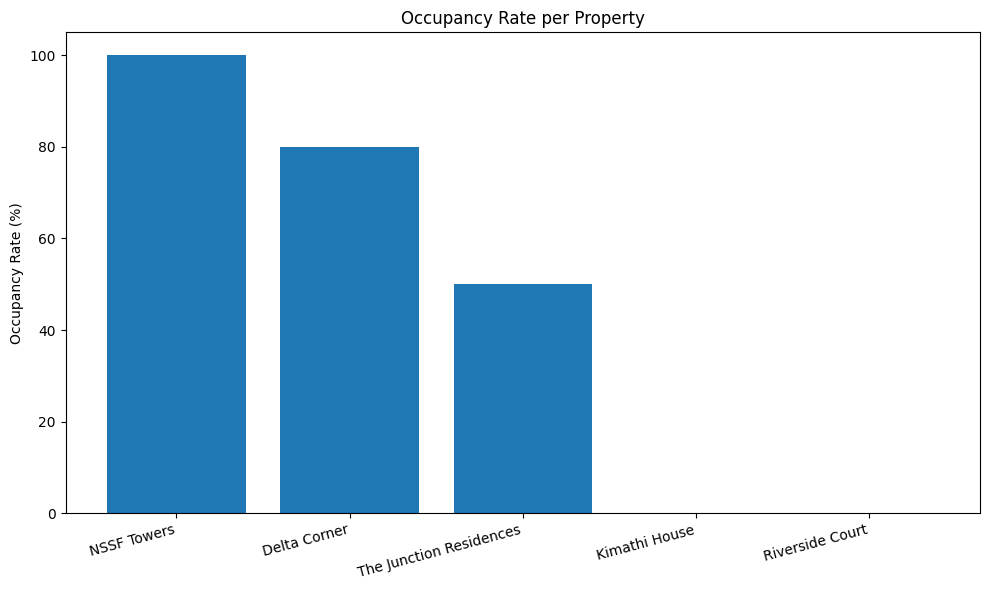

In [36]:
# Step 1: Count Occupied Units
occupied_units = df_cleaned[df_cleaned['valid_lease'] == 1].drop_duplicates(subset='unit_name')
df_occupied_count = occupied_units.groupby('property_name').size().reset_index(name='occupied_units')

# Step 2: Count Total Units
df_units_properties = pd.merge(df_units, df_properties, left_on='property_id', right_on='id', suffixes=('_unit', '_property'))
df_total_units_count = df_units_properties.groupby('name_property').size().reset_index(name='total_units')
df_total_units_count.rename(columns={'name_property': 'property_name'}, inplace=True)

# Step 3: Merge, Calculate Rate, and Sort
df_occupancy = pd.merge(df_total_units_count, df_occupied_count, on='property_name', how='left').fillna(0)
df_occupancy['occupancy_rate'] = (df_occupancy['occupied_units'] / df_occupancy['total_units']) * 100
df_occupancy_sorted = df_occupancy.sort_values(by='occupancy_rate', ascending=False)

# Create the visualization
plt.figure(figsize=(10, 6))
plt.bar(df_occupancy_sorted['property_name'], df_occupancy_sorted['occupancy_rate'])
plt.xticks(rotation=15, ha='right')
plt.ylabel('Occupancy Rate (%)')
plt.title('Occupancy Rate per Property')
plt.tight_layout()
plt.show()

Top 3 Properties by Arrears

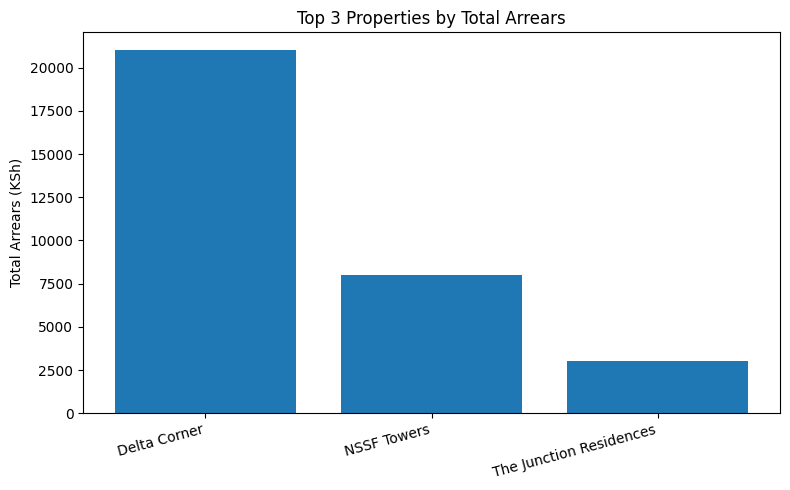

In [37]:
df_arrears_by_property = df_cleaned.groupby('property_name')['arrears'].sum().reset_index()
df_top3_arrears = df_arrears_by_property.sort_values(by='arrears', ascending=False).head(3)

plt.figure(figsize=(8, 5))
plt.bar(df_top3_arrears['property_name'], df_top3_arrears['arrears'])
plt.xticks(rotation=15, ha='right')
plt.ylabel('Total Arrears (KSh)')
plt.title('Top 3 Properties by Total Arrears')
plt.tight_layout()
plt.show()

Average Monthly Rent per Property and per Location

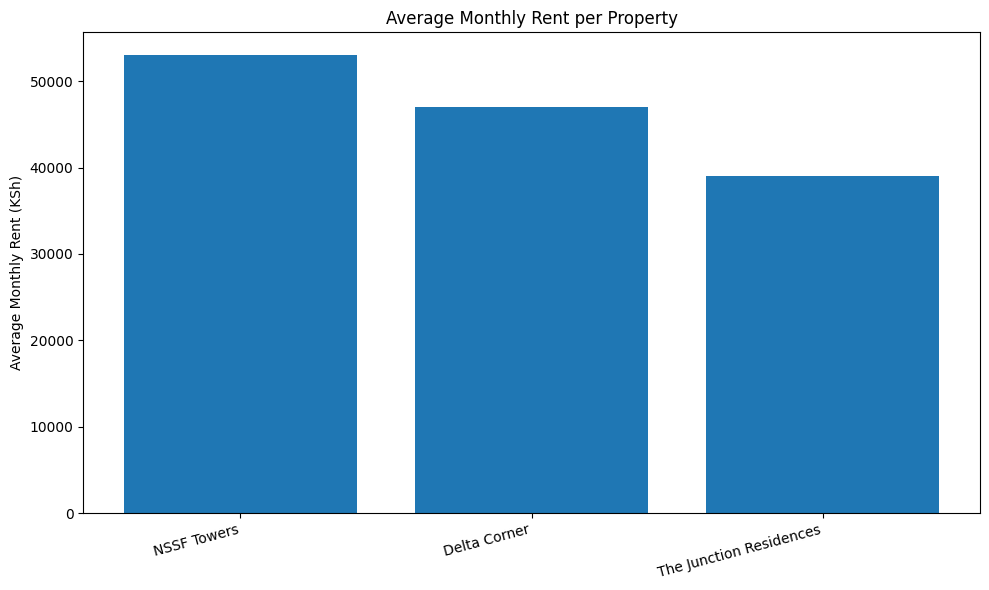

In [38]:
df_avg_rent_property = df_cleaned.groupby('property_name')['rent_per_month'].mean().reset_index(name='avg_monthly_rent')
df_avg_rent_property_sorted = df_avg_rent_property.sort_values(by='avg_monthly_rent', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(df_avg_rent_property_sorted['property_name'], df_avg_rent_property_sorted['avg_monthly_rent'])
plt.xticks(rotation=15, ha='right')
plt.ylabel('Average Monthly Rent (KSh)')
plt.title('Average Monthly Rent per Property')
plt.tight_layout()
plt.show()

Average Monthly Rent per Location

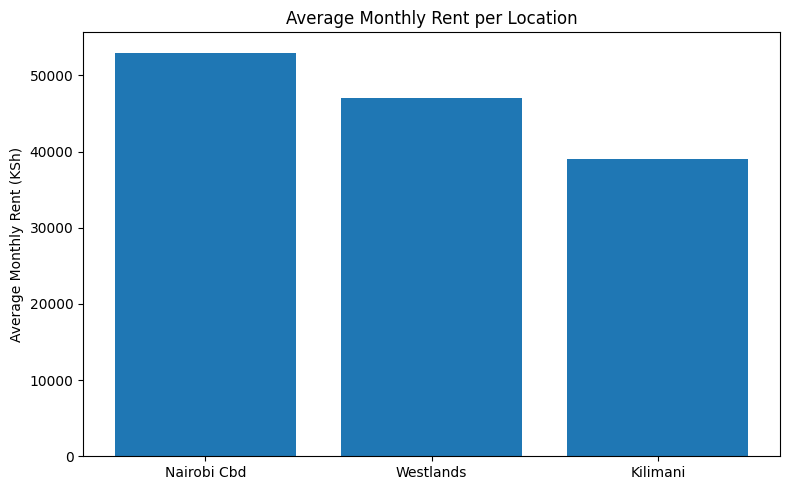

In [39]:
df_avg_rent_location = df_cleaned.groupby('location_name')['rent_per_month'].mean().reset_index(name='avg_monthly_rent')
df_avg_rent_location_sorted = df_avg_rent_location.sort_values(by='avg_monthly_rent', ascending=False)

plt.figure(figsize=(8, 5))
plt.bar(df_avg_rent_location_sorted['location_name'], df_avg_rent_location_sorted['avg_monthly_rent'])
plt.xticks(rotation=0)
plt.ylabel('Average Monthly Rent (KSh)')
plt.title('Average Monthly Rent per Location')
plt.tight_layout()
plt.show()